In [1]:
import sys,os
import warnings
import time as tm

import NSSEA.models as nsm
import NSSEA as ns

import numpy as np
import scipy.stats as sc
import xarray as xr
import pandas as pd

import seaborn as sns
import matplotlib.backends.backend_pdf as mpdf
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatch

import matplotlib.ticker
sns.set_context("paper")

from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
from matplotlib.ticker import StrMethodFormatter, NullFormatter,AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset,inset_axes

import random
random.seed(42)

In [2]:
pathFig=os.path.abspath(os.getcwd())+"/Output/"
print(pathFig)

/home/barbauxo/Documents/05_Autres Activités/Paper: Integrating  non-stationarity and  uncertainty in design life levels/Output/


In [3]:
ns_law      = nsm.GEV()

# I) Dealing with non-stationary: Equivalent reliability

In [4]:
#Parameters
T1=2050 #Period of interest 2050-2100
T2=2100
p=1/1000 # Annual risk of excess
time_period    = np.arange( 1850 , 2101 , 1 , dtype = int ) # Total  time period

#Stationnary GEV Parameters
mu=0
sigma=0.5
xi=-0.2
#non-Stationnary parameters
mu1=0.07
sigma1=0


In [5]:
def RLP(p,mu,sigma,xi):
    #Return Level given p (probability of excess) and mu,sigma,xi (gev parameters)
    return mu-(sigma/xi)*(1-(-np.log(1-p))**(-xi))
RL_s=RLP(p,mu,np.exp(sigma),xi)
RL_s

6.172698892171272

In [6]:
#Return levels for various p values
print(RLP(1/10,mu,np.exp(sigma),xi),RLP(1/100,mu,np.exp(sigma),xi),RLP(1/1000,mu,np.exp(sigma),xi))

2.987637018022618 4.9584703019412 6.172698892171272


In [7]:
para_stationnaire = pd.DataFrame({
"year": time_period,
"mu":[mu]*len(time_period) ,
"sigma": [np.exp(sigma)]*len(time_period),
"xi": [xi]*len(time_period)
})
#Create time serie
para_stationnaire

,year,mu,sigma,xi
0,1850,0,1.648721,-0.2
1,1851,0,1.648721,-0.2
2,1852,0,1.648721,-0.2
3,1853,0,1.648721,-0.2
4,1854,0,1.648721,-0.2
...,...,...,...,...
246,2096,0,1.648721,-0.2
247,2097,0,1.648721,-0.2
248,2098,0,1.648721,-0.2
249,2099,0,1.648721,-0.2


In [8]:
#EQR Functions


def proba_period_mult(x,para,T1,T2,xlen):
    #total probability of excess over the period T1-T2
    proba_full=np.zeros(shape=( T2+1-T1,xlen))
    for i in range(T1,T2+1):
        proba_full[i-T1]=np.asarray([sc.genextreme.cdf(x, -para[para["year"]==i]["xi"],para[para["year"]==i]["mu"],para[para["year"]==i]["sigma"]) ])
    proba_z=np.prod(proba_full,axis=0)   
    return proba_z




def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def Find_EQR(para,p,T1,T2,xlen=1000):
    #Find EQR Value
    min_val_s=sc.genextreme.ppf((1-p), -para[para["year"]==T1]["xi"],para[para["year"]==T1]["mu"],para[para["year"]==T1]["sigma"])
    max_val_s=sc.genextreme.ppf((1-p), -para[para["year"]==T2]["xi"],para[para["year"]==T2]["mu"],para[para["year"]==T2]["sigma"])
    x=np.linspace(max_val_s[0],min_val_s[0] ,xlen) #Valeurs a tester
    test_val_s=proba_period_mult(x,para,T1,T2,xlen)  #Probabilité sur la periode t1 t2 pour chaque valeur
    Eq_Reliability=(1-p)**(T2-T1+1) #Formule EQR
    idx=find_nearest(test_val_s, Eq_Reliability) # Valeur dont la proba est la plus prche de lEQR
    return x[idx],test_val_s[idx],Eq_Reliability

In [9]:

EQR_s=Find_EQR(para_stationnaire,p,T1,T2,xlen=1000)[0]
EQR_s

6.172698892171273

## Non stationnarity 

In [10]:
#Covariable (linear with time after tmin)
def X_t(t,tmin=2000):
    return (t-2050)*(t>(tmin-1))

In [11]:
para_non_stationnaire = pd.DataFrame({
"year": time_period,
"mu":[mu+mu1*X_t(t) for t in time_period] ,
"sigma": [np.exp(sigma+sigma1*X_t(t)) for t in time_period],
"xi": [xi]*len(time_period)
})
para_non_stationnaire

,year,mu,sigma,xi
0,1850,0.00,1.648721,-0.2
1,1851,0.00,1.648721,-0.2
2,1852,0.00,1.648721,-0.2
3,1853,0.00,1.648721,-0.2
4,1854,0.00,1.648721,-0.2
...,...,...,...,...
246,2096,3.22,1.648721,-0.2
247,2097,3.29,1.648721,-0.2
248,2098,3.36,1.648721,-0.2
249,2099,3.43,1.648721,-0.2


In [12]:
RL_t=[RLP(p,para_non_stationnaire[para_non_stationnaire["year"]==i]["mu"],para_non_stationnaire[para_non_stationnaire["year"]==i]["sigma"],para_non_stationnaire[para_non_stationnaire["year"]==i]["xi"]).values[0] for i in time_period]
RL_t

[6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,
 6.172698892171272,


In [13]:
EQR_ns=Find_EQR(para_non_stationnaire,p,T1,T2,xlen=1000)[0]
EQR_ns

8.71974593921832

In [14]:
para_non_stationnaire["RL"]=RL_t
para_non_stationnaire[para_non_stationnaire["RL"]>8.6]

,year,mu,sigma,xi,RL
235,2085,2.45,1.648721,-0.2,8.622699
236,2086,2.52,1.648721,-0.2,8.692699
237,2087,2.59,1.648721,-0.2,8.762699
238,2088,2.66,1.648721,-0.2,8.832699
239,2089,2.73,1.648721,-0.2,8.902699
240,2090,2.80,1.648721,-0.2,8.972699
241,2091,2.87,1.648721,-0.2,9.042699
242,2092,2.94,1.648721,-0.2,9.112699
243,2093,3.01,1.648721,-0.2,9.182699
244,2094,3.08,1.648721,-0.2,9.252699


In [15]:
RL_s

6.172698892171272

In [16]:
ymin=np.min(RL_t)
ymax=np.max(RL_t)
print(ymin, ymax)

2.672698892171272 9.672698892171272


In [17]:
time_period[-1],RL_t[-1]

(2100, 9.672698892171272)

In [18]:
time_period[200],RL_t[200]

(2050, 6.172698892171272)

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_60532/3638213172.py:25: SyntaxWarning: invalid escape sequence '\m'
  title=plt.title("Stationary case \n $\mu(t)=0$",backgroundcolor='lavender',verticalalignment="bottom", horizontalalignment="center")
/tmp/ipykernel_60532/3638213172.py:53: SyntaxWarning: invalid escape sequence '\m'
  title=plt.title("Non-stationary case \n $\mu(t)=0.7(t-2050)$",backgroundcolor='lavender',verticalalignment="bottom", horizontalalignment="center")


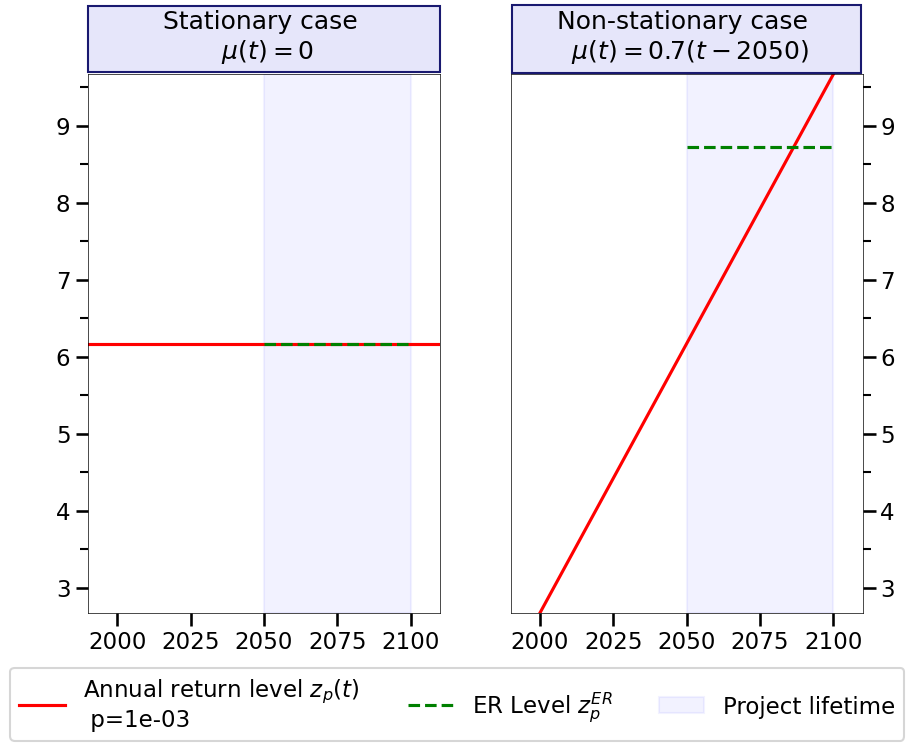

In [19]:
ofile=os.path.join(  pathFig+"Figure1.pdf" )
pdf= mpdf.PdfPages( ofile )
fig = plt.figure( figsize = (10,7) )
sns.set_context("talk")

#stationnaire
ax = fig.add_subplot( 1 ,2 ,  1 )

label = ["Project lifetime","Annual return level $z_p(t)$ \n p="+"{:.0e}".format(p),  "ER Level $z_p^{ER}$"]


plt.axhline(y=RL_s, color='r', linestyle='-',label=label[1])
plt.hlines(y=EQR_s, xmin=T1, xmax=T2,color='g', linestyle='--',label=label[2])
ax.axvspan(T1, T2, alpha=0.05, color='blue',label=label[0])

ax.set_xlim(1990, 2110)
ax.xaxis.set_major_locator(MultipleLocator(25))

ax.set_ylim(ymin, ymax)
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d°C'))

ax.legend( ncol=3,bbox_to_anchor=(2.35, -.08))

title=plt.title("Stationary case \n $\mu(t)=0$",backgroundcolor='lavender',verticalalignment="bottom", horizontalalignment="center")
title._bbox_patch._mutation_aspect = 0.08
title.get_bbox_patch().set_boxstyle("square", pad=3)
title.get_bbox_patch().set(edgecolor="midnightblue")

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)


#non stationnaire
ax = fig.add_subplot( 1 ,2 ,  2 )

ax.plot( time_period[150:] , RL_t[150:], color = "red" )

plt.hlines(y=EQR_ns, xmin=T1, xmax=T2,color='g', linestyle='--')
ax.axvspan(T1, T2, alpha=0.05, color='blue')
ax.set_xlim(1990, 2110)
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.set_ylim(ymin, ymax)
#ax.get_yaxis().set_ticks([])
ax.yaxis.tick_right()
ax.yaxis.set_minor_locator(MultipleLocator(0.5))




ax.set(ylabel=None)

title=plt.title("Non-stationary case \n $\mu(t)=0.7(t-2050)$",backgroundcolor='lavender',verticalalignment="bottom", horizontalalignment="center")
#title._bbox_patch._mutation_aspect = 0.1

title._bbox_patch._mutation_aspect = 0.15
title.get_bbox_patch().set_boxstyle("square", pad=1.8)
title.get_bbox_patch().set(edgecolor="midnightblue")


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)


#fig.suptitle('Main title but very very very \n long long long long')
#fig.subplots_adjust(top=0.88)

plt.show()
pdf.savefig(fig, bbox_inches = 'tight')
plt.close(fig)
pdf.close()


# II) Accounting for estimation uncertainty: Predictive distribution

In [20]:
#Parametrization
# mu ~ N(36,0.5)
#log(sigma) ~ N(0.5,0.05)
# xi~ N(-0.2,0.05)

In [21]:
mu_m=0
mu_cov=0.5
sigma_m=0.5
sigma_cov=0.05
xi_m=-0.2
xi_cov=0.05

p=1/10000
ci=0.05
tirage_para=1000 #Number of parameter draws
tirage_pred=10000 #Number of draws for each predictive

In [22]:
#Sampling parameters
mu_sample=sc.norm.rvs(size=tirage_para,loc=mu_m,scale=mu_cov)
sigma_sample=np.exp(sc.norm.rvs(size=tirage_para,loc=sigma_m,scale=sigma_cov))
xi_sample=sc.norm.rvs(size=tirage_para,loc=xi_m,scale=xi_cov)


In [23]:
samples_para = pd.DataFrame({
"mu":mu_sample ,
"sigma": sigma_sample,
"xi": xi_sample
})
samples_para

,mu,sigma,xi
0,-0.568419,1.659071,-0.142024
1,0.912723,1.687468,-0.204180
2,0.462888,1.667370,-0.187042
3,0.629863,1.771956,-0.101549
4,0.213419,1.598315,-0.221349
...,...,...,...
995,-0.344518,1.693340,-0.231761
996,-0.629908,1.564867,-0.183870
997,-0.603502,1.586821,-0.220570
998,-0.126974,1.617234,-0.228317


In [24]:
para_names=["mu","sigma","xi"]
true_para_names=['$\\mu$', '$\\sigma$',  '$\\xi$']
ci=0.05

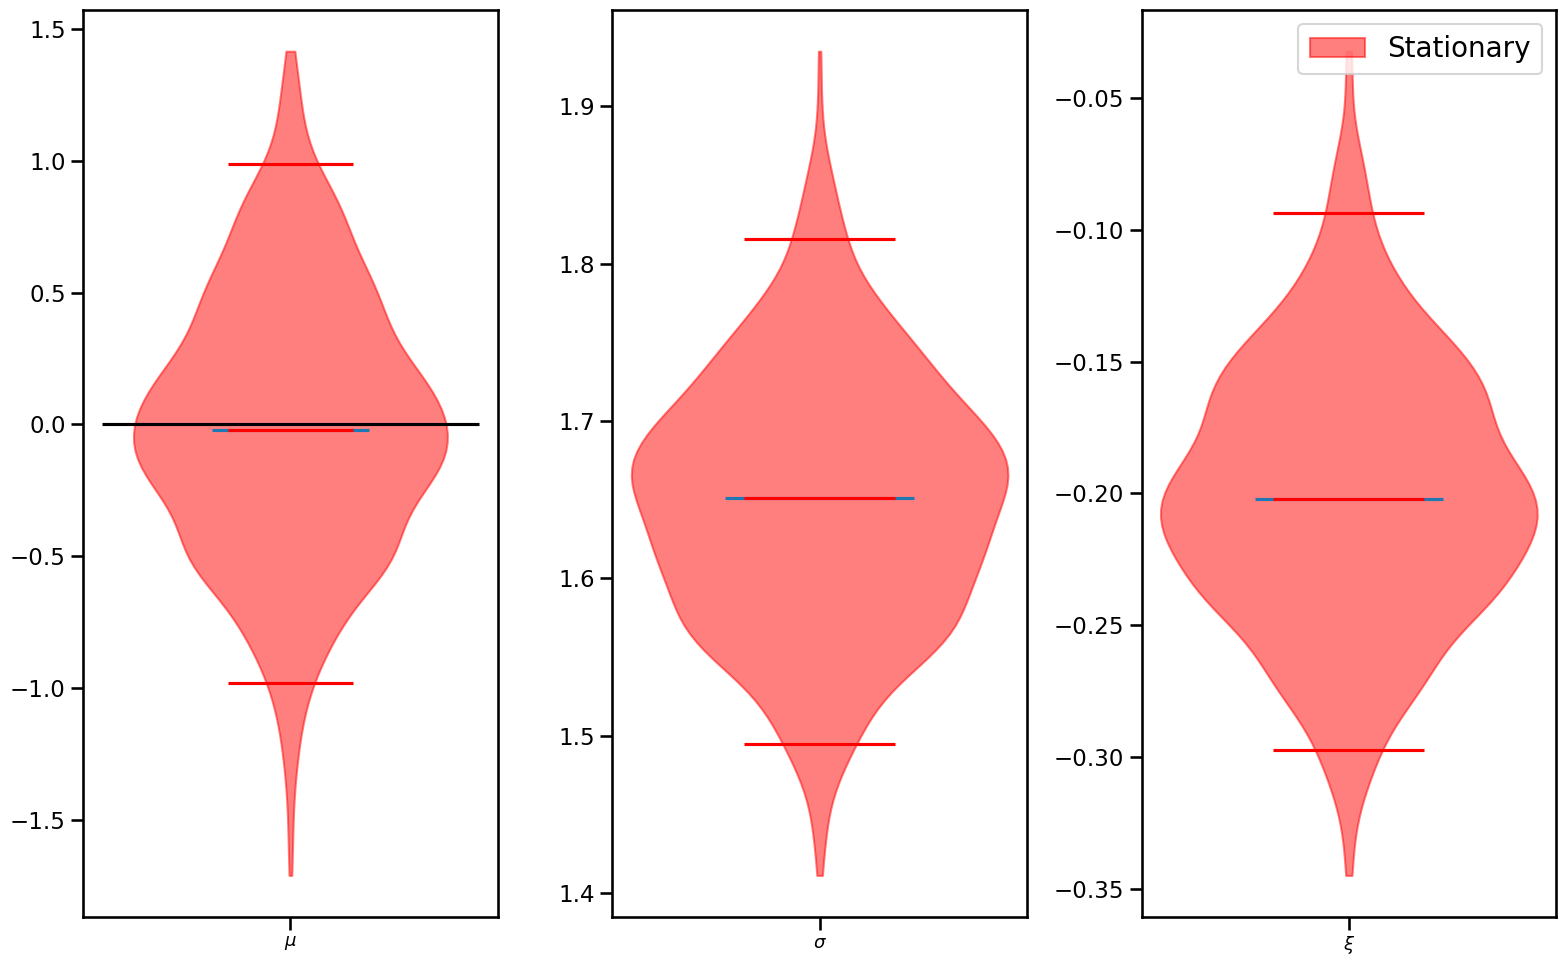

In [25]:
custom_params = {"axes.spines.bottom": True,"axes.spines.right": True,"axes.spines.left": True, "axes.spines.top":True}
#sns.set_theme(style="whitegrid",rc=custom_params)
    
ofile=os.path.join( pathFig , ("Figure_Unused_1.pdf" ))
pdf = mpdf.PdfPages( ofile )


kwargs = {  "showmeans" : False , "showextrema" : False , "showmedians" : True }
fig = plt.figure( figsize = ( 16 , 10 ) )

#sub_def=df[['para.1','para.2','para.3','para.4','para.5']]
label = ["Stationary"]
legend = [mplpatch.Patch(facecolor = c , edgecolor = c , label = l , alpha = 0.5 ) for c,l in zip(["red"],label)]


for i in range(len(para_names)):
    para=para_names[i]
    ax = fig.add_subplot(1,len(para_names),i+1)
   
    vplot = ax.violinplot( samples_para[para]  , **kwargs )
    
    ql_para=samples_para[para].quantile(ci/2)
    ax.hlines( ql_para , 1 - 0.1 , 1 + 0.1 , color = "red" )
    qu_para=samples_para[para].quantile(1-ci/2)
    ax.hlines( qu_para , 1 - 0.1 , 1 + 0.1 , color = "red" )
    BE_para=samples_para[para].median()
    ax.hlines( BE_para , 1 - 0.1 , 1 + 0.1 , color = "red", label= "Non-stationnary" )
    
    for pc in vplot["bodies"]:
        pc.set_facecolor("red")
        pc.set_edgecolor("red")
        pc.set_alpha(0.5)



    ax.set_xticks([1])
    
    xticks = [ true_para_names[i] ]
    ax.set_xticklabels( xticks , fontsize = 13 )
    if samples_para[para].min()*samples_para[para].max()<0:
        ax.hlines( 0 , 1-0.3 , 1+0.3, color = "black" )

ax.legend( handles = legend , fontsize = 20 )
fig.set_tight_layout(True)

#fig.suptitle( "With X sampling", fontsize = 25 )
plt.show()
pdf.savefig(fig)
plt.close(fig)
pdf.close()

In [26]:
samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])
samples_para

,mu,sigma,xi,RL_0.0001
0,-0.568419,1.659071,-0.142024,7.955217
1,0.912723,1.687468,-0.204180,7.916937
2,0.462888,1.667370,-0.187042,7.785354
3,0.629863,1.771956,-0.101549,11.230829
4,0.213419,1.598315,-0.221349,6.494072
...,...,...,...,...
995,-0.344518,1.693340,-0.231761,6.097598
996,-0.629908,1.564867,-0.183870,6.315911
997,-0.603502,1.586821,-0.220570,5.647269
998,-0.126974,1.617234,-0.228317,6.091392


In [27]:
#Credibility intervals
#RL_BE=samples_para["RL_"+str(p)].mean()
#RL_up=samples_para["RL_"+str(p)].quantile(1-ci/2)
#RL_low=samples_para["RL_"+str(p)].quantile(ci/2)
#print(RL_up,RL_BE,RL_low)

In [28]:
#Credibility intervals 0.05 (used for figures)
Q_up=samples_para["RL_"+str(p)].quantile(1-0.05/2)
Q_low=samples_para["RL_"+str(p)].quantile(0.05/2)
BE_estim=samples_para["RL_"+str(p)].median()

In [29]:
#Median of Return Levels
Q_med=samples_para["RL_"+str(p)].median()
Q_med

6.9089939420776325

In [30]:

#Predictive sampling
if not os.path.exists((pathFig+"tirages_pred_Toymodele.nc") ):
    law_coef_bay   = xr.DataArray( np.zeros( (tirage_para,tirage_pred) ) ,
                                  coords = [ range(tirage_para) ,range(tirage_pred)  ] ,
                                  dims = ["coef","Tirage"] )
    for i in range(tirage_para):
        s=samples_para.iloc[i,0:3].values
        law_coef_bay.loc[i,:]=sc.genextreme.rvs( c=-s[2],loc=s[0],
                            scale=s[1],size=tirage_pred)
    law_coef_bay.to_netcdf(pathFig+"tirages_pred_Toymodele.nc")
law_coef_bay=xr.open_dataarray(pathFig+"tirages_pred_Toymodele.nc")
#Tirages pred
data_theta=law_coef_bay.to_pandas().T.melt()

pred_estim=np.quantile(data_theta['value'],1-p)
print(pred_estim)
data_theta

8.650880319688488


,coef,value
0,0,-0.399178
1,0,-2.569723
2,0,-1.351611
3,0,0.913162
4,0,-1.971993
...,...,...
9999995,999,-0.755994
9999996,999,0.607142
9999997,999,2.987700
9999998,999,0.566338


In [31]:
xmin=data_theta.min().value
xmax=data_theta.max().value
ymin=0
ymax=0.35

pal = sns.color_palette('deep')

x = np.linspace(xmin, xmax,num=500)

In [32]:
#multidimensionnal Median for parameters
#https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points
import numpy as np
from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1
theta_be=geometric_median(samples_para.iloc[:,0:3], eps=1e-5)
val_BE=sc.genextreme.pdf( c=-theta_be[2],loc=theta_be[0],scale=theta_be[1],x=x)
val_BE_cdf=sc.genextreme.cdf( c=-theta_be[2],loc=theta_be[0],
                            scale=theta_be[1],x=x)
Q_BE=RLP(p,theta_be["mu"],theta_be["sigma"],theta_be["xi"])

/tmp/ipykernel_60532/727457254.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_BE=sc.genextreme.pdf( c=-theta_be[2],loc=theta_be[0],scale=theta_be[1],x=x)
/tmp/ipykernel_60532/727457254.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_BE_cdf=sc.genextreme.cdf( c=-theta_be[2],loc=theta_be[0],
/tmp/ipykernel_60532/727457254.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale=theta_be[1],x=x)


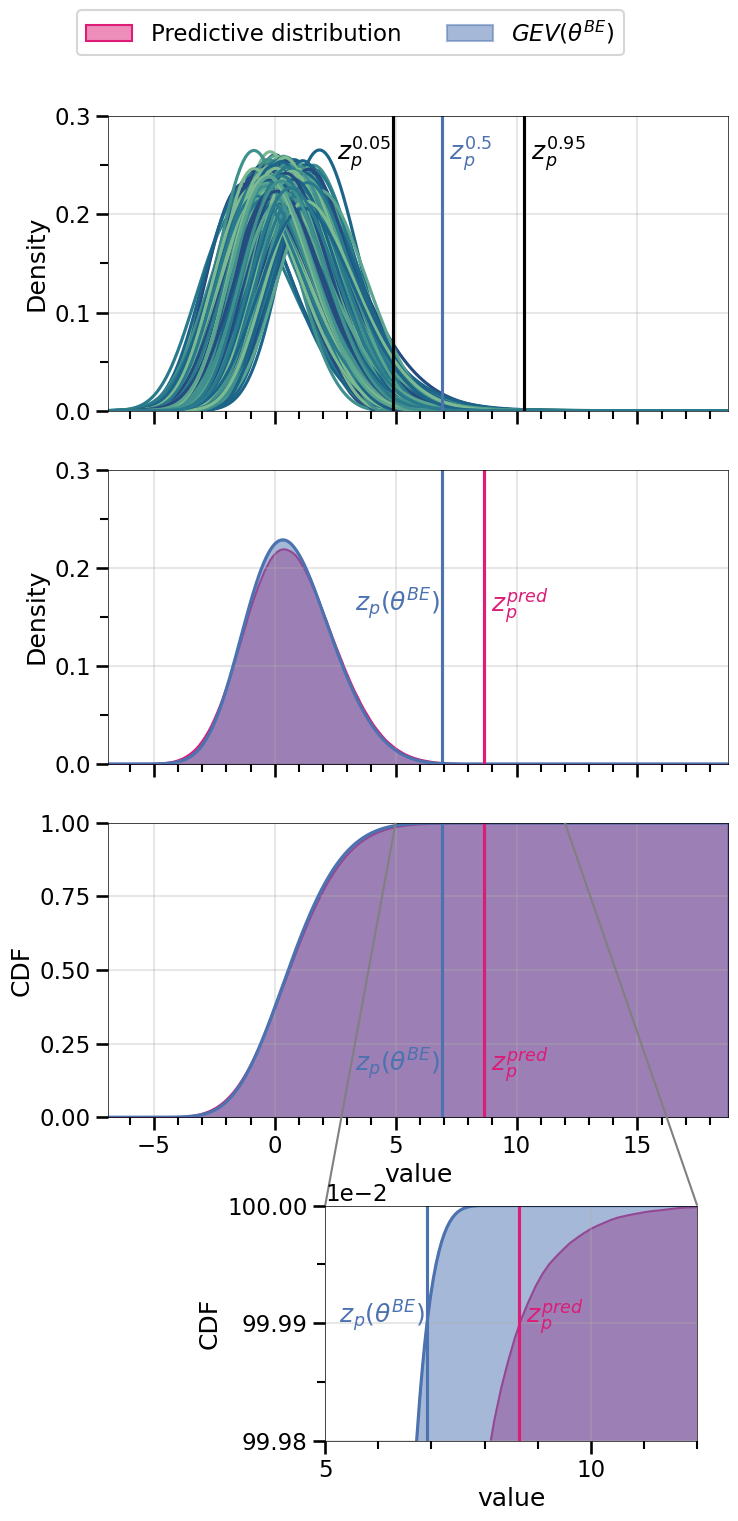

In [33]:

#Figure 2
#custom_params = {"axes.spines.bottom": True,"axes.spines.right": True,"axes.spines.left": True, "axes.spines.top":True}
#sns.set_theme(style="whitegrid",palette='crest',rc=custom_params)
sns.set_palette('crest')  
ofile=os.path.join(  pathFig+"Figure2.pdf" )
pdf= mpdf.PdfPages( ofile )
fig = plt.figure( figsize = (8,13) )
#sns.set_context("talk")

#All sample
ax = fig.add_subplot( 3 ,1 ,  1 )


samples_select_2=np.unique(data_theta['coef'])
for s in samples_select_2:
    theta_sample=samples_para.iloc[s,0:3].values
    val_sample=sc.genextreme.pdf( c=-theta_sample[2],loc=theta_sample[0],
                            scale=theta_sample[1],x=x)
    ax2=plt.plot(x, val_sample)
##add estimation be and ic   
plt.axvline(x=Q_low,color="black")
plt.text(Q_low, 0.255, '$z_p^{0.05}$ ',color="black",ha='right')
plt.axvline(x=Q_up,color="black")
plt.text(Q_up, 0.255, ' $z_p^{0.95}$',color="black")
#plt.vlines(x=Q_med, ymin=0, ymax=0.155,color='#4c72b0')
plt.axvline(x=Q_med,color='#4c72b0')
plt.text(Q_med, 0.255, ' $z_p^{0.5}$',color='#4c72b0')

frame1 = plt.gca()
frame1.axes.set(ylabel="Density")
frame1.axes.set(xlim=(xmin, xmax))
frame1.axes.set(ylim=(0, 0.3))
frame1.axes.set(xticklabels=[])
frame1.axes.set(xlabel=None)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
plt.grid(alpha=0.3)    
#BE et predictive
ax = fig.add_subplot( 3 ,1 ,  2 )
sns.kdeplot(data=data_theta, x='value',
            color='#dd1c77', cut=0, fill=True, common_norm=False,
            alpha=0.5,legend=True,label="Predictive distribution")
ax2=plt.plot(x, val_BE,color='#4c72b0')
plt.fill_between(x,val_BE,alpha=0.5,color='#4c72b0',label="$GEV(\\theta^{BE})$")
##Add estim
plt.axvline(x=Q_BE,color='#4c72b0')
plt.text(Q_BE, 0.155, '$z_p( \\theta^{BE})$ ',color='#4c72b0',ha='right')
##add estim
plt.axvline(x=pred_estim,color='#dd1c77')
plt.text(pred_estim, 0.155, ' $z_p^{pred}$',color='#dd1c77')
frame1 = plt.gca()
frame1.axes.set(xlim=(xmin, xmax))
frame1.axes.set(xticklabels=[])
frame1.axes.set(ylim=(0, 0.3))
frame1.axes.set(xlabel=None)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
plt.grid(alpha=0.3)    
ax.legend( ncol=2,bbox_to_anchor=(0.85, 2.6))

#Zoom BE et predicitve
ax = fig.add_subplot( 3 ,1 ,  3 )

sns.kdeplot(data=data_theta, x='value',
            color='#dd1c77', cut=0, fill=True, common_norm=False,
            alpha=0.5,legend=True,label="Predictive distribution",cumulative=True)
ax2=plt.plot(x, val_BE_cdf,color='#4c72b0')
plt.fill_between(x,val_BE_cdf,alpha=0.5,color='#4c72b0',label="$GEV(\\theta^{BE})$")
##Add estim
plt.axvline(x=Q_BE,color='#4c72b0')
plt.text(Q_BE, 0.155, '$z_p( \\theta^{BE})$ ',color='#4c72b0',ha='right')
##add estim
plt.axvline(x=pred_estim,color='#dd1c77')
plt.text(pred_estim, 0.155, ' $z_p^{pred}$',color='#dd1c77')
frame1 = plt.gca()
frame1.axes.set(xlim=(xmin, xmax))

frame1.axes.set(ylim=(0,1))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.set(ylabel="CDF")
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
plt.grid(alpha=0.3)


axins = inset_axes(ax, width="60%", height="80%",
                   bbox_to_anchor=(0.35, -1.3, 1, 1),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)

sns.kdeplot(data=data_theta, x='value',color='#dd1c77',
            cut=0, fill=True, common_norm=False, alpha=0.5,legend=True,label="Prédictive",cumulative=True)
ax2=plt.plot(x, val_BE_cdf,color='#4c72b0')
plt.fill_between(x,val_BE_cdf,alpha=0.5,color='#4c72b0')
#Add estim
new_y_min=0.9998
hauteur=(new_y_min+1)/2
plt.axvline(x=Q_BE,color='#4c72b0')
plt.text(Q_BE, hauteur, ' $z_p( \\theta^{BE})$ ',color='#4c72b0',ha='right')

#add estim
plt.axvline(x=pred_estim,color='#dd1c77')
plt.text(pred_estim, hauteur, ' $z_p^{pred}$',color='#dd1c77')


axins.set(xlim=(5, 12))
axins.xaxis.set_major_locator(MultipleLocator(5))
axins.xaxis.set_minor_locator(MultipleLocator(1))
axins.yaxis.set_major_locator(MultipleLocator(0.0001))
axins.yaxis.set_minor_locator(MultipleLocator(0.00005))
plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,-2))
axins.set(ylim=(new_y_min, 1))
axins.set(ylabel="CDF")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(0.5)
plt.grid(alpha=0.3)
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")



plt.show()
pdf.savefig(fig, bbox_inches = 'tight')
plt.close(fig)
pdf.close()

## Illustration for various values of p

In [34]:
#Boucle all T

x_axis=np.logspace(1,5,201)

predict_meth_max=np.zeros( len(x_axis))
estim_BE=np.zeros( len(x_axis))
estim_low_99=np.zeros( len(x_axis))
estim_up_99=np.zeros( len(x_axis))

estim_low_95=np.zeros( len(x_axis))
estim_up_95=np.zeros( len(x_axis))

estim_low_90=np.zeros( len(x_axis))
estim_up_90=np.zeros( len(x_axis))

estim_low_70=np.zeros( len(x_axis))
estim_up_70=np.zeros( len(x_axis))
xlen=1000

#law_coef_bay=pred_proba_max(Eq_Reliability,params,T1,T2,size=1000)



for i in range(len(x_axis)):
    T=x_axis[i]
    p=1/T
    #pred
    predict_meth_max[i]=(float(law_coef_bay.quantile(1-1/T)))
    
    #estimatif
    #IC

    
    samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])

    ci=0.01

    estim_low_99[i]=samples_para["RL_"+str(p)].quantile(ci/2)
    estim_up_99[i]=samples_para["RL_"+str(p)].quantile(1-ci/2)
    ci=0.05
    estim_low_95[i]=samples_para["RL_"+str(p)].quantile(ci/2)
    estim_up_95[i]=samples_para["RL_"+str(p)].quantile(1-ci/2)
    ci=0.1
    estim_low_90[i]=samples_para["RL_"+str(p)].quantile(ci/2)
    estim_up_90[i]=samples_para["RL_"+str(p)].quantile(1-ci/2)
    
    ci=0.3
    estim_low_70[i]=samples_para["RL_"+str(p)].quantile(ci/2)
    estim_up_70[i]=samples_para["RL_"+str(p)].quantile(1-ci/2)
    

    estim_BE[i]=samples_para["RL_"+str(p)].median()


    print(T)

10.0
10.471285480508996
10.964781961431852
11.481536214968829
12.02264434617413
12.589254117941675
13.182567385564074
13.803842646028853
14.454397707459272
15.13561248436208
15.848931924611133
16.595869074375607
17.378008287493753
18.197008586099834
19.054607179632473
19.952623149688797
20.892961308540396
21.87761623949553
22.908676527677724
23.9883291901949
25.118864315095795
26.302679918953814
27.542287033381662
28.84031503126606
30.19951720402016
31.622776601683793
33.11311214825911
34.673685045253166
36.30780547701014
38.018939632056124
39.810717055349734
41.68693834703355
43.65158322401661
45.708818961487516
47.86300923226385
50.11872336272725
52.48074602497726
54.954087385762456
57.543993733715695
60.25595860743578
63.09573444801933
66.06934480075961
69.18309709189363
72.44359600749898
75.85775750291836
79.43282347242814
83.17637711026708
87.09635899560806
91.20108393559097
95.49925860214358
100.0
104.71285480508996
109.64781961431851
114.81536214968828
120.22644346174131
125.892

/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


912.0108393559096


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


954.992586021436


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1000.0


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1047.1285480508996


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1096.4781961431852


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1148.1536214968828


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1202.2644346174131


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1258.9254117941675


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1318.2567385564075


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1380.3842646028852


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1445.439770745928


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1513.5612484362086


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1584.893192461114


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1659.5869074375614


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1737.8008287493763


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1819.7008586099844


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1905.4607179632483


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


1995.262314968881


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


2089.296130854039


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


2187.761623949552


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


2290.8676527677726


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


2398.83291901949


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


2511.88643150958


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


2630.2679918953813


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


2754.2287033381663


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


2884.031503126606


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


3019.9517204020162


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


3162.2776601683795


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


3311.311214825911


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


3467.368504525317


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


3630.780547701014


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


3801.8939632056126


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


3981.0717055349733


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


4168.693834703355


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


4365.158322401661


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


4570.881896148751


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


4786.300923226385


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


5011.872336272725


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


5248.074602497728


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


5495.408738576249


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


5754.399373371572


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


6025.5958607435805


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


6309.573444801937


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


6606.934480075957


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


6918.309709189362


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


7244.359600749898


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


7585.775750291836


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


7943.282347242814


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


8317.63771102671


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


8709.635899560806


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


9120.108393559096


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


9549.92586021436
10000.0


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


10471.285480508985


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


10964.78196143185


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


11481.53621496884


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


12022.644346174131


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


12589.254117941662


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


13182.567385564074


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


13803.842646028867


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


14454.39770745928


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


15135.612484362071


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


15848.93192461114


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


16595.86907437563


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


17378.00828749376


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


18197.008586099826


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


19054.607179632483


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


19952.62314968883


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


20892.96130854041


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


21877.616239495517


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


22908.6765276777


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


23988.329190194898


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


25118.864315095823


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


26302.679918953814


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


27542.28703338163


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


28840.31503126606


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


30199.51720402019


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


31622.776601683792


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


33113.112148259075


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


34673.685045253165


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


36307.80547701017


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


38018.93963205613


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


39810.71705534969


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


41686.93834703355


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


43651.58322401666


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


45708.818961487515


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


47863.0092322638


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


50118.72336272725


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


52480.746024977336


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


54954.08738576248


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


57543.993733715666


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


60255.95860743581


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


63095.73444801943


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


66069.34480075965


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


69183.09709189362


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


72443.59600749891


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


75857.75750291836


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


79432.82347242821


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


83176.37711026709


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


87096.35899560797


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


91201.08393559097


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


95499.25860214369
100000.0


/tmp/ipykernel_60532/714187920.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samples_para["RL_"+str(p)]=RLP(p,samples_para["mu"],samples_para["sigma"],samples_para["xi"])


<>:42: SyntaxWarning: invalid escape sequence '\%'
<>:42: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_60532/4266913785.py:42: SyntaxWarning: invalid escape sequence '\%'
  label='$z_{10^{-2}}^{99\%}> z_{2*10^{-3}}^{70\%}$')


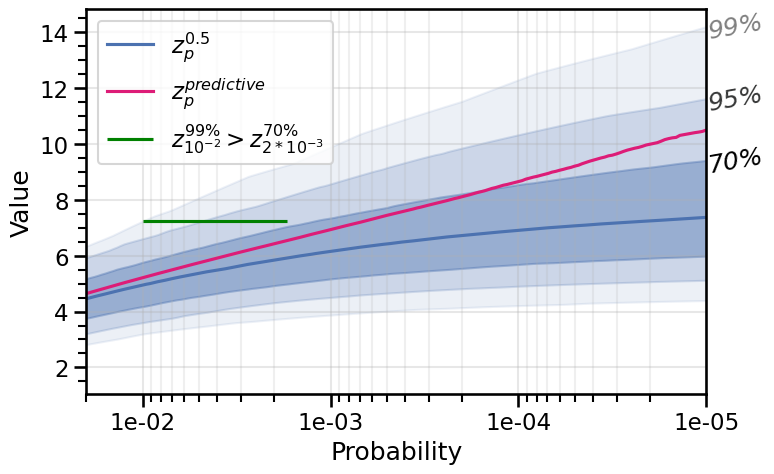

In [35]:
#x_axis=np.array([50,100,1000,10000,100000])
x_axis_b=[1/i for i in x_axis]

palette = {
    '$z_p^{0.5}$': '#4c72b0',
    '$z_p^{predictive}$': '#dd1c77'
}


#prépare data
data_graph1=pd.DataFrame({'x':x_axis_b,'value':estim_BE,'method':'$z_p^{0.5}$'} )
data_graph2=pd.DataFrame({'x':x_axis_b,'value':predict_meth_max,'method':'$z_p^{predictive}$'} )
#data_graph3=pd.DataFrame({'x':x_axis_b,'value':predict_meth2,'method':'Prédictive moyenne'} )
data_graph=pd.concat([data_graph1,data_graph2])#,data_graph3])

ofile=os.path.join(   pathFig+"Figure3.pdf" )
pdf= mpdf.PdfPages( ofile )
#graph
fig ,ax = plt.subplots( figsize = ( 8 , 5 ) )

sns.lineplot(x='x', y='value',hue='method', data=data_graph,palette=palette)
plt.fill_between(x_axis_b, estim_low_70, estim_up_70, alpha=.4,color='#4c72b0')
#plt.fill_between(x_axis_b, estim_low_90, estim_up_90, alpha=.2,color='#4c72b0')
plt.fill_between(x_axis_b, estim_low_95, estim_up_95, alpha=.2,color='#4c72b0')
plt.fill_between(x_axis_b, estim_low_99, estim_up_99, alpha=.1,color='#4c72b0')

place=100000
place_b=1/place
ax.text(place_b, estim_up_99[x_axis==place][0], "99%", ha = "left",va = "center" ,rotation = +10,#fontsize = 12,
        fontstyle = "oblique", color = "grey",)
ax.text(place_b, estim_up_95[x_axis==place][0], "95%", ha = "left",va = "center" ,rotation = +10,#fontsize = 12,
        fontstyle = "oblique", color = "#363737",)
#ax.text(place_b, estim_up_90[x_axis==place][0], "90%", ha = "left",va = "center" ,rotation = +10,#fontsize = 12,
#        fontstyle = "oblique", color = "#363737",)
ax.text(place_b, estim_up_70[x_axis==place][0], "70%", ha = "left",va = "center" ,rotation = +10,#fontsize = 12,
        fontstyle = "oblique", color = "black",)



plt.hlines(y=estim_up_99[x_axis==100][0], xmin=1/100, xmax=1/587
           ,color='green',
          label='$z_{10^{-2}}^{99\%}> z_{2*10^{-3}}^{70\%}$')

plt.legend( loc='upper left')
plt.ylabel('Value')
plt.xlabel('Probability')

#plt.xscale('log')
ax.set_xscale('log')
ax.xaxis.grid(True, which='minor',alpha=0.2)
ax.set(xlim=(1/50, 1/100000))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0e}'))

#ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='x', which='major', bottom=True)
#plt.gca().invert_xaxis()


ax.tick_params(axis='y', which='minor', bottom=True)
ax.tick_params(axis='y', which='major', bottom=True)
ax.yaxis.set_minor_locator(AutoMinorLocator())


for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(0.5)
plt.grid(alpha=0.3)

pdf.savefig(fig, bbox_inches = 'tight')
plt.show()
plt.close(fig)
pdf.close()